In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# download data from signate for google colab
!pip install -q signate 
import signate
!signate token --email=atakeuchi.ds@gmail.com --password=miyo5472

     |████████████████████████████████| 143kB 6.8MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
The API Token has been downloaded successfully.


In [ ]:
# Check competition and file ID
#!signate list
!signate files --competition-id=362

  fileId  name               title                          size  updated_at
--------  -----------------  -----------------------  ----------  -------------------
    1797  train_images.zip   学習用画像データ          715128832  2021-01-28 09:36:29
    1785  train_images.csv   学習用画像マッピングcsv       36292  2021-01-25 13:34:34
    1796  test_images.zip    評価用画像データ         1148640320  2021-01-28 09:36:31
    1786  test_images.csv    評価用画像管理用csv           50974  2021-01-28 09:36:31
    1784  sample_submit.csv  応募用サンプルファイル        54271  2021-01-28 09:36:31


In [ ]:
# download
!signate download --competition-id=362 --file-id=1797 
!signate download --competition-id=362 --file-id=1785

!unzip train_images.zip


In [12]:
# sample size by class
import pandas as pd
train_csv = pd.read_csv('train_images.csv')
print(train_csv.head())
train_csv.class_num.value_counts()

                               id  class_num
0  20191230111846704116348556.jpg          1
1  20191230115302414627693914.jpg          2
2  20191230125312374548523858.jpg          3
3  20191230105929394260738600.jpg          1
4  20191230104136120462839151.jpg          1


0    400
1    256
2    236
3    211
Name: class_num, dtype: int64

In [33]:
import cv2
import glob
import matplotlib.pyplot as plt
import re
import os
import numpy as np
import shutil

TRAIN_INDIR = "./train_images"
TEST_INDIR = "./test_images"
TRAIN_OUTDIR = "/content/drive/MyDrive/signate_lemon/train_pr"
TEST_OUTDIR = "/content/drive/MyDrive/signate_lemon/test_pr/unknown"
TARGET_SIZE = (400,400)
MARGIN_RATIO = 0.1 

(640, 640, 3)


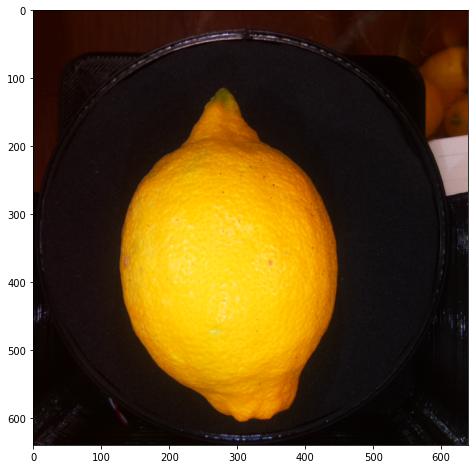

In [53]:
# sample image
#img = cv2.imread(os.path.join(TRAIN_INDIR, train_csv.loc[14,'id']))
img = cv2.imread(os.path.join(TRAIN_INDIR, '20191230104254359861520981.jpg'))
plt.figure(figsize=(8,8))
plt.imshow(img[:,:,::-1])
print(img.shape)

In [46]:
# function to crop target
def crop(path, size, margin):
  '''
  path : str, path to the image file
  size : tuple, output image size
  margin: float, % of max(w,h) of cutout rectangle

  find target object as contour with area that occupies 5-80% of total area
  add margin of specified percent to the  envelop rectangle
  output resized cropped image
  '''
  img = cv2.imread(path)
  width, height, _ = img.shape
  grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(grayed, (5,5) ,0)
  _, binary = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  contours , hierarchy = cv2.findContours(binary , cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE )

  min_areasize = height * width // 25
  max_areasize = height * width * 4 // 5
  cur_areasize = 0
  for i in range(0, len(contours)):
      if len(contours[i]) > 0:
          area = cv2.contourArea(contours[i])
          if area < min_areasize or area > max_areasize:
              continue
          rect = contours[i]
          x, y, w, h = cv2.boundingRect(rect)
          if w * h > cur_areasize:
              cur_areasize = w * h
              max_rect = (x, y, w, h)
  x, y, w, h = max_rect
  s = max(w,h)
  m = int(s * margin)

  if w >=h:
    shift = int((w - h) / 2)
    cropped = img[max(0, y-shift-m):min((y-shift-m+s+2*m), height), max(0, x-m):min((x+s+m), width)]
  else:
    shift = int((h - w) / 2)
    cropped = img[max(0, y-m):min((y+s+m), height), max(0, x-shift-m):min((x-shift-m+s+2*m), width)]    
  return cv2.resize(cropped, size)

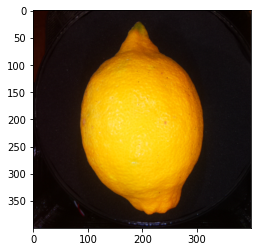

In [55]:
# check
cropped = crop(os.path.join(TRAIN_INDIR, '20191230104254359861520981.jpg'), TARGET_SIZE, MARGIN_RATIO)
plt.imshow(cropped[:,:,::-1])


In [56]:
# prepare directory if not exist
if os.path.exists(TRAIN_OUTDIR):
  shutil.rmtree(TRAIN_OUTDIR)
os.makedirs(TRAIN_OUTDIR)
for i in range(0,4): 
  os.makedirs(os.path.join(TRAIN_OUTDIR,str(i)))

In [57]:
for row in train_csv.itertuples():
  in_path = os.path.join(TRAIN_INDIR,row[1])
  out_path = os.path.join(TRAIN_OUTDIR, str(row[2]), row[1])
  output_im = crop(in_path, TARGET_SIZE, MARGIN_RATIO)
  cv2.imwrite(out_path, output_im, [cv2.IMWRITE_JPEG_QUALITY, 100])

In [59]:
# same treatment for test
#!signate download --competition-id=362 --file-id=1796
#!signate download --competition-id=362 --file-id=1786  
#!unzip test_images.zip

test_csv = pd.read_csv('test_images.csv')
if os.path.exists(TEST_OUTDIR):
  shutil.rmtree(TEST_OUTDIR)
os.makedirs(TEST_OUTDIR)
os.makedirs(os.path.join(TEST_OUTDIR,'unknown'))

for row in test_csv.itertuples():
  in_path = os.path.join(TEST_INDIR,row[1])
  out_path = os.path.join(TEST_OUTDIR, row[1])
  output_im = crop(in_path, TARGET_SIZE, MARGIN_RATIO)
  cv2.imwrite(out_path, output_im, [cv2.IMWRITE_JPEG_QUALITY, 100])